# Evaluate a pretrained detector on custom coco style dataset

In [1]:
from PIL import Image
import torch
import json
import numpy as np
import cv2
import torchvision.transforms.functional as F
import os
import sys
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

/home/marcelln/miniconda3/envs/datawran/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


My imports

In [2]:
sys.path.append(os.path.join(sys.path[0], '../tooling/'))
from myloader import CocoDetection

### Prepare dataset

Visualizing and verifying dataset

In [3]:
img_dir = os.path.abspath("../data/coco_train_m_01_False_matchdrill/")
annotation = img_dir + "/annot.json"
dataset = CocoDetection(root=img_dir, annFile=annotation)
img, target = dataset[200]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


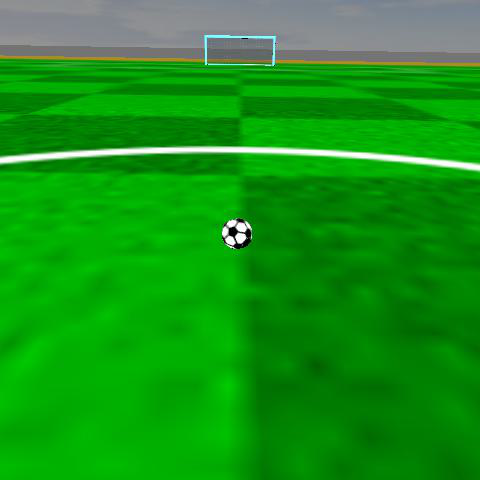

In [4]:
img

In [5]:
target

[{'area': 1210.0783751073045,
  'iscrowd': 0,
  'bbox': [218.5720089590433,
   215.45744738294923,
   34.78618080656893,
   34.78618080656893],
  'category_id': 37,
  'ignore': 0,
  'segmentation': [],
  'image_id': 201,
  'id': 104}]

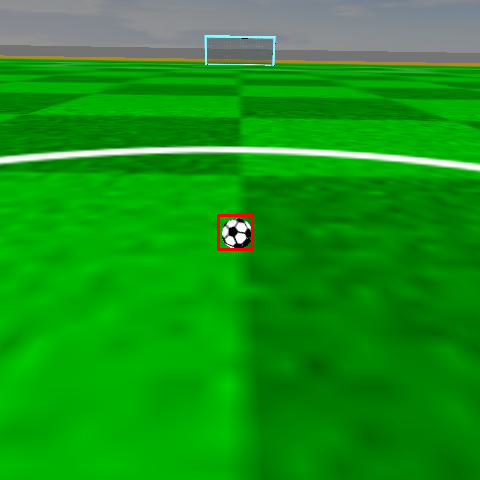

In [6]:
x1 = int(target[0]["bbox"][0])
y1 = int(target[0]["bbox"][1])
x2 = int(x1+target[0]["bbox"][2])
y2 = int(y1+target[0]["bbox"][3])

display_img = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (255, 0, 0), 2)
F.to_pil_image(display_img)

### Prepare detector

Load pretrained model

In [7]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /home/marcelln/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-18 Python-3.10.10 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)



requirements: /home/marcelln/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Perform inference for one test image

In [8]:
result = model(img)

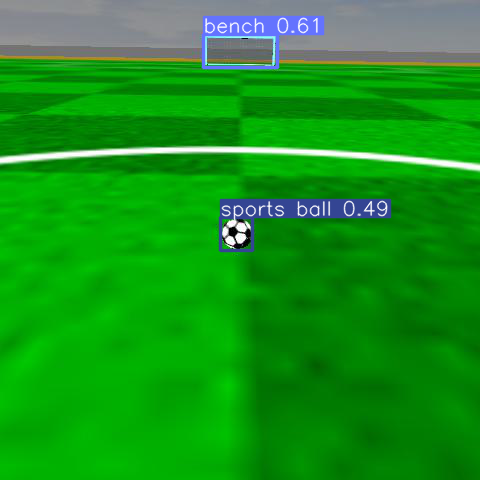

In [9]:
result.show()

In [10]:
result.pandas().xyxy[0] 

,xmin,ymin,xmax,ymax,confidence,class,name
0,203.503189,34.002052,277.087708,67.356918,0.611106,13,bench
1,220.820847,217.259491,252.396332,250.938080,0.491606,32,sports ball


### Evaluate mAP

Perform inference on dataset and convert to coco style results

In [11]:
preds = []
for idx, id in enumerate(dataset.ids):
    img, target = dataset[idx]

    # Prepare prediction 
    result = model(img)
    detections = result.xyxy[0]  # Batch size of 1
    if len(detections)>0:
        for detect in detections:  # [x_min, y_min, x_max, y_max, score, class]
            scores = detect[4].tolist()
            
            boxes = detect[0:4].type(torch.int64).tolist()
            # from xyxy to xywh
            boxes[2] = boxes[2]-boxes[0]
            boxes[3] = boxes[3]-boxes[1]
            
            labels = detect[5].type(torch.int64).tolist()
            
            # Consider only ball detections
            if labels == 32:
                labels = 37  # Convert prediction to coco
                pass
            else:
                continue
            
            preds.append(
                dict(
                    image_id = target[0]['image_id'],
                    category_id=labels,
                    bbox=boxes,
                    score=round(scores,3),
                )
            )

Save results

In [12]:
resFile = "./detection_cocoresults.json"
with open(resFile, 'w') as out_file:
    json.dump(preds, out_file)

Load ground truth annotations and predictions

In [13]:
cocoGt = COCO(annotation)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [14]:
cocoDt = cocoGt.loadRes(resFile)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [15]:
cocoDt.anns[1]

{'image_id': 1,
 'category_id': 37,
 'bbox': [222, 216, 35, 36],
 'score': 0.845,
 'segmentation': [[222, 216, 222, 252, 257, 252, 257, 216]],
 'area': 1260,
 'id': 1,
 'iscrowd': 0}

In [16]:
cocoGt.anns[1]

{'area': 1425.348424266535,
 'iscrowd': 0,
 'bbox': [220.2835684169982,
  214.42691174261884,
  37.75378688643743,
  37.75378688643743],
 'category_id': 37,
 'ignore': 0,
 'segmentation': [],
 'image_id': 1,
 'id': 1}

In [17]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=480x480>,
 [{'area': 1425.348424266535,
   'iscrowd': 0,
   'bbox': [220.2835684169982,
    214.42691174261884,
    37.75378688643743,
    37.75378688643743],
   'category_id': 37,
   'ignore': 0,
   'segmentation': [],
   'image_id': 1,
   'id': 1}])

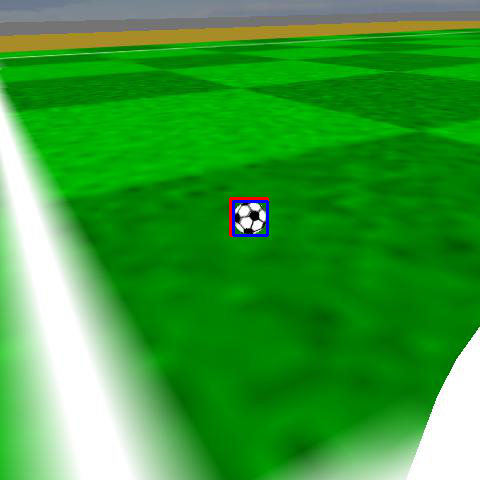

In [18]:
gx1 = int(cocoGt.anns[7]["bbox"][0])
gy1 = int(cocoGt.anns[7]["bbox"][1])
gx2 = int(gx1+cocoGt.anns[7]["bbox"][2])
gy2 = int(gy1+cocoGt.anns[7]["bbox"][3])
display_img = cv2.rectangle(np.array(dataset[cocoDt.anns[7]['image_id']-1][0]), (gx1, gy1), (gx2, gy2), (255, 0, 0), 2)

px1 = int(cocoDt.anns[7]["bbox"][0])
py1 = int(cocoDt.anns[7]["bbox"][1])
px2 = int(px1+cocoDt.anns[7]["bbox"][2])
py2 = int(py1+cocoDt.anns[7]["bbox"][3])
display_img = cv2.rectangle(display_img, (px1, py1), (px2, py2), (0, 0, 255), 2)

F.to_pil_image(display_img)

Prepare evaluation function

In [19]:
cocoEval = COCOeval(cocoGt=cocoGt, cocoDt=cocoDt, iouType='bbox')
cocoEval.params.imgIds  = dataset.ids  # Evaluate all images
cocoEval.params.useCats = True
cocoEval.params.catIds = 37

Compute mAP scores

In [20]:
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.613
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.862
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.648
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=